In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import tree  # For visualizing the decision tree
#from statsmodels.discrete.discrete_model import MNLogit #Removed for simplification
#import statsmodels.api as sm #Removed for simplification
import seaborn as sns
import numpy as np

In [4]:
 df = pd.read_excel('dataset_1.xlsx') # No path needed, it's in the root
#     print("Data loaded successfully!")

In [5]:
print("Original DataFrame Head:")
print(df.head())

Original DataFrame Head:
   Sno.      Firm code     SIC Industry  Manufacturing  DJSI      Dates  Year  \
0     1   GM US EQUITY  3711.0       37              1     1 2016-12-31  2016   
1     1   GM US EQUITY  3711.0       37              1     1 2017-12-31  2017   
2     1   GM US EQUITY  3711.0       37              1     1 2018-12-31  2018   
3     2  BAC US EQUITY  6021.0       60              0     1 2016-12-31  2016   
4     2  BAC US EQUITY  6021.0       60              0     1 2017-12-31  2017   

   Year_code  NUM_OF_EMPLOYEES  ...  TOT_GHG_CO2_EM_INTENS_PER_SALES  \
0          1          225000.0  ...                          52.3025   
1          2          180000.0  ...                          44.1413   
2          3          173000.0  ...                          41.2618   
3          1          208000.0  ...                          11.2828   
4          2          209376.0  ...                           9.1593   

   PCT_WOMEN_EMPLOYEES  PCT_WOMEN_ON_BOARD  PCT_WOMEN_M

In [6]:
# --- DEBUGGING: Check for duplicate columns ---
print("\nChecking for duplicate column names:")
if any(df.columns.duplicated()):
    print("ERROR: Duplicate column names found!")
    print(df.columns[df.columns.duplicated(keep=False)])
    df = df.loc[:, ~df.columns.duplicated()].copy()


Checking for duplicate column names:


In [7]:
# 2. & 3. Gather Numerical Columns and Drop Unnecessary Ones
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
cols_to_exclude = ['Year', 'Year_code', 'Sno.']  # Include 'Sno.'
numerical_cols = [col for col in numerical_cols if col not in cols_to_exclude]
df = df.drop(columns=cols_to_exclude, errors='ignore')

In [8]:
# Added year filter:
years_to_exclude = [2016, 2017, 2018]
df = df[df['Dates'].dt.year.isin(years_to_exclude)]

In [9]:
print("\nDataFrame after dropping columns:")
print(df.head())


DataFrame after dropping columns:
       Firm code     SIC Industry  Manufacturing  DJSI      Dates  \
0   GM US EQUITY  3711.0       37              1     1 2016-12-31   
1   GM US EQUITY  3711.0       37              1     1 2017-12-31   
2   GM US EQUITY  3711.0       37              1     1 2018-12-31   
3  BAC US EQUITY  6021.0       60              0     1 2016-12-31   
4  BAC US EQUITY  6021.0       60              0     1 2017-12-31   

   NUM_OF_EMPLOYEES  NET_ASSETS  NET_INCOME  SALES_REV_TURN  ...  \
0          225000.0     44075.0      9427.0        149184.0  ...   
1          180000.0     36200.0     -3864.0        145588.0  ...   
2          173000.0     42777.0      8014.0        147049.0  ...   
3          208000.0    266195.0     17822.0         93662.0  ...   
4          209376.0    267146.0     18232.0        100264.0  ...   

   TOT_GHG_CO2_EM_INTENS_PER_SALES  PCT_WOMEN_EMPLOYEES  PCT_WOMEN_ON_BOARD  \
0                          52.3025                 18.2       

In [10]:
# 4. Drop columns AH and later
try:
    ah_index = df.columns.get_loc('AH')
    df = df.iloc[:, :ah_index]
except KeyError:
    print("Column 'AH' not found.  Skipping column drop.")

Column 'AH' not found.  Skipping column drop.


In [11]:
# 5. Impute missing values
imputer = SimpleImputer(strategy='mean')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])
print("\nDataFrame after imputation:")
print(df.head())


DataFrame after imputation:
       Firm code     SIC Industry  Manufacturing  DJSI      Dates  \
0   GM US EQUITY  3711.0       37            1.0   1.0 2016-12-31   
1   GM US EQUITY  3711.0       37            1.0   1.0 2017-12-31   
2   GM US EQUITY  3711.0       37            1.0   1.0 2018-12-31   
3  BAC US EQUITY  6021.0       60            0.0   1.0 2016-12-31   
4  BAC US EQUITY  6021.0       60            0.0   1.0 2017-12-31   

   NUM_OF_EMPLOYEES  NET_ASSETS  NET_INCOME  SALES_REV_TURN  ...  \
0          225000.0     44075.0      9427.0        149184.0  ...   
1          180000.0     36200.0     -3864.0        145588.0  ...   
2          173000.0     42777.0      8014.0        147049.0  ...   
3          208000.0    266195.0     17822.0         93662.0  ...   
4          209376.0    267146.0     18232.0        100264.0  ...   

   TOT_GHG_CO2_EM_INTENS_PER_SALES  PCT_WOMEN_EMPLOYEES  PCT_WOMEN_ON_BOARD  \
0                          52.3025                 18.2             

In [12]:
# 7. Prepare for Clustering
clustering_df = df[numerical_cols]
print("\nDataFrame for Clustering:")
print(clustering_df.head())


DataFrame for Clustering:
      SIC  Manufacturing  DJSI  NUM_OF_EMPLOYEES  NET_ASSETS  NET_INCOME  \
0  3711.0            1.0   1.0          225000.0     44075.0      9427.0   
1  3711.0            1.0   1.0          180000.0     36200.0     -3864.0   
2  3711.0            1.0   1.0          173000.0     42777.0      8014.0   
3  6021.0            0.0   1.0          208000.0    266195.0     17822.0   
4  6021.0            0.0   1.0          209376.0    267146.0     18232.0   

   SALES_REV_TURN  HISTORICAL_MARKET_CAP  RETURN_ON_ASSET  ROA_TO_ROE  ...  \
0        149184.0             52260.0000           4.5319      0.2012  ...   
1        145588.0             57386.0000          -1.7799      0.1816  ...   
2        147049.0             46830.0000           3.6442      0.1700  ...   
3         93662.0            222163.0258           0.8227      0.1210  ...   
4        100264.0            303681.1678           0.8159      0.1193  ...   

   TOT_GHG_CO2_EM_INTENS_PER_SALES  PCT_WOMEN_E

In [13]:
# 8. Perform clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_df)
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(scaled_data)

In [14]:
# 9. Save clusters
df['Cluster'] = clusters
print("\nDataFrame with Cluster Assignments:")
print(df.head())


DataFrame with Cluster Assignments:
       Firm code     SIC Industry  Manufacturing  DJSI      Dates  \
0   GM US EQUITY  3711.0       37            1.0   1.0 2016-12-31   
1   GM US EQUITY  3711.0       37            1.0   1.0 2017-12-31   
2   GM US EQUITY  3711.0       37            1.0   1.0 2018-12-31   
3  BAC US EQUITY  6021.0       60            0.0   1.0 2016-12-31   
4  BAC US EQUITY  6021.0       60            0.0   1.0 2017-12-31   

   NUM_OF_EMPLOYEES  NET_ASSETS  NET_INCOME  SALES_REV_TURN  ...  \
0          225000.0     44075.0      9427.0        149184.0  ...   
1          180000.0     36200.0     -3864.0        145588.0  ...   
2          173000.0     42777.0      8014.0        147049.0  ...   
3          208000.0    266195.0     17822.0         93662.0  ...   
4          209376.0    267146.0     18232.0        100264.0  ...   

   PCT_WOMEN_EMPLOYEES  PCT_WOMEN_ON_BOARD  PCT_WOMEN_MGT  \
0                 18.2              45.454           32.0   
1                

In [15]:
# 1. Correlation Matrix (for manual inspection)
numerical_df = df[numerical_cols + ['Cluster']]  # Select ONLY numerical columns + Cluster
correlation_matrix = numerical_df.corr()
print("\nCorrelation Matrix:")
#print(correlation_matrix) #Removed for space.


Correlation Matrix:


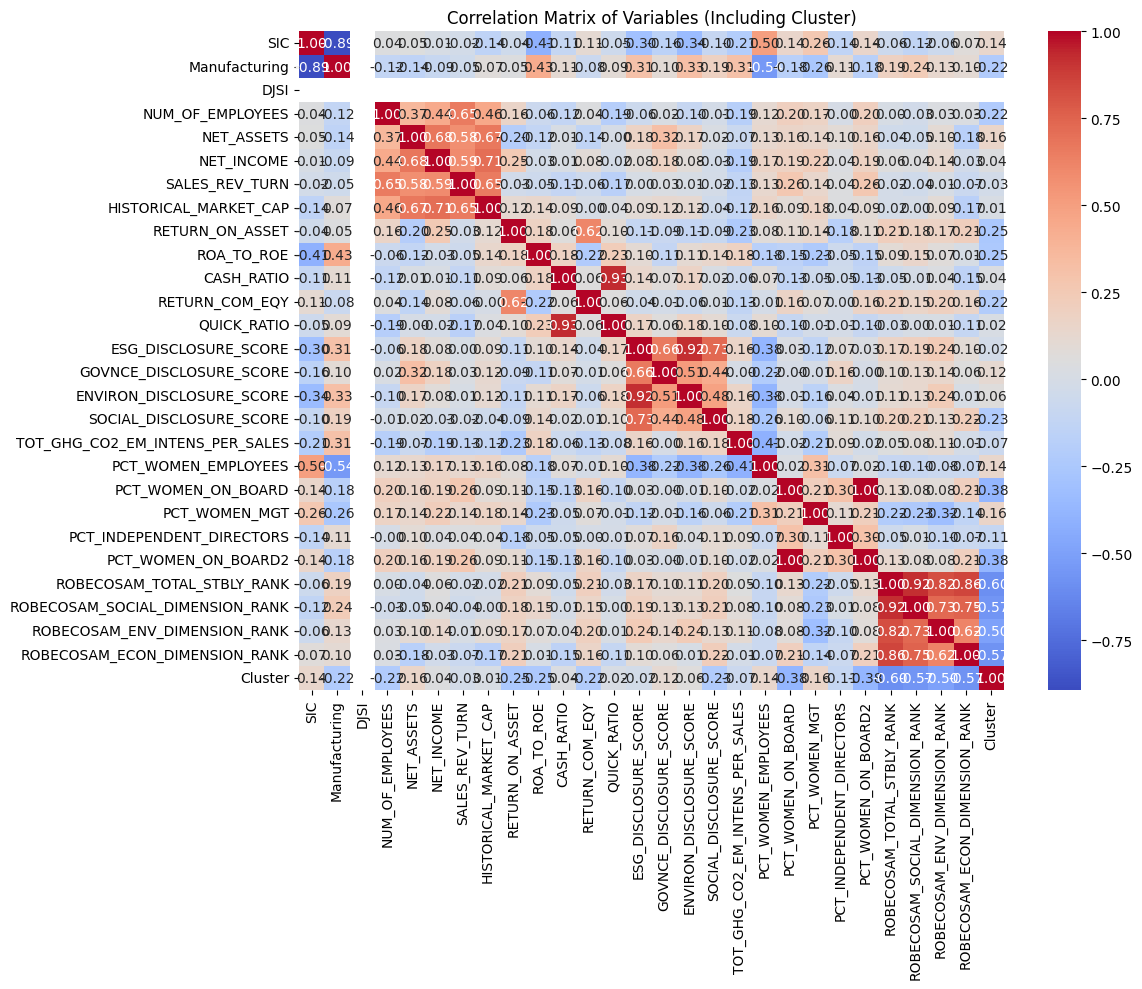

In [16]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Variables (Including Cluster)')
plt.tight_layout()
plt.show()

In [27]:
# 2. Random Forest (Robust Error Handling)
X = df[numerical_cols]  # Features
y = df['Cluster']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(random_state=42, n_estimators=100, oob_score=True)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results:")
if np.isnan(y_pred_rf).any():
    print("ERROR: NaNs found in Random Forest predictions.  Skipping report.")
else:
    print(classification_report(y_test, y_pred_rf))
    print("\nConfusion Matrix (Random Forest):")
    print(confusion_matrix(y_test, y_pred_rf))
    mse = mean_squared_error(y_test, y_pred_rf)
    print(f"\nMean Squared Error (MSE): {mse}")
    r2 = r2_score(y_test, y_pred_rf)
    print(f"R-squared (R2): {r2}")
    print(f"Out-of-Bag (OOB) Error: {1 - rf_model.oob_score_:.4f}")

feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("\nFeature Importances (Random Forest):")
print(feature_importances)


Random Forest Results:
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00         1
           3       0.93      0.81      0.87        16

    accuracy                           0.90        40
   macro avg       0.91      0.92      0.91        40
weighted avg       0.90      0.90      0.90        40


Confusion Matrix (Random Forest):
[[ 7  0  0  1]
 [ 0 15  0  0]
 [ 0  0  1  0]
 [ 2  1  0 13]]

Mean Squared Error (MSE): 0.775
R-squared (R2): 0.45969498910675377
Out-of-Bag (OOB) Error: 0.1410

Feature Importances (Random Forest):
                            feature  importance
24  ROBECOSAM_SOCIAL_DIMENSION_RANK    0.088000
15         ENVIRON_DISCLOSURE_SCORE    0.083436
23       ROBECOSAM_TOTAL_STBLY_RANK    0.074574
13             ESG_DISCLOSURE_SCORE    0.060068
22              PCT_WOMEN_ON_BOARD2    0.058284
4                  

In [18]:
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values('importance', ascending=False)
print("\nFeature Importances (Random Forest):")
print(feature_importances)


Feature Importances (Random Forest):
                            feature  importance
24  ROBECOSAM_SOCIAL_DIMENSION_RANK    0.095466
23       ROBECOSAM_TOTAL_STBLY_RANK    0.092206
13             ESG_DISCLOSURE_SCORE    0.078343
15         ENVIRON_DISCLOSURE_SCORE    0.069901
4                        NET_ASSETS    0.053040
19               PCT_WOMEN_ON_BOARD    0.051823
22              PCT_WOMEN_ON_BOARD2    0.047820
0                               SIC    0.045297
26    ROBECOSAM_ECON_DIMENSION_RANK    0.042624
7             HISTORICAL_MARKET_CAP    0.041712
9                        ROA_TO_ROE    0.038431
18              PCT_WOMEN_EMPLOYEES    0.037545
1                     Manufacturing    0.035843
6                    SALES_REV_TURN    0.034764
14          GOVNCE_DISCLOSURE_SCORE    0.033583
3                  NUM_OF_EMPLOYEES    0.033498
5                        NET_INCOME    0.029094
17  TOT_GHG_CO2_EM_INTENS_PER_SALES    0.023016
11                   RETURN_COM_EQY    0.019387
25

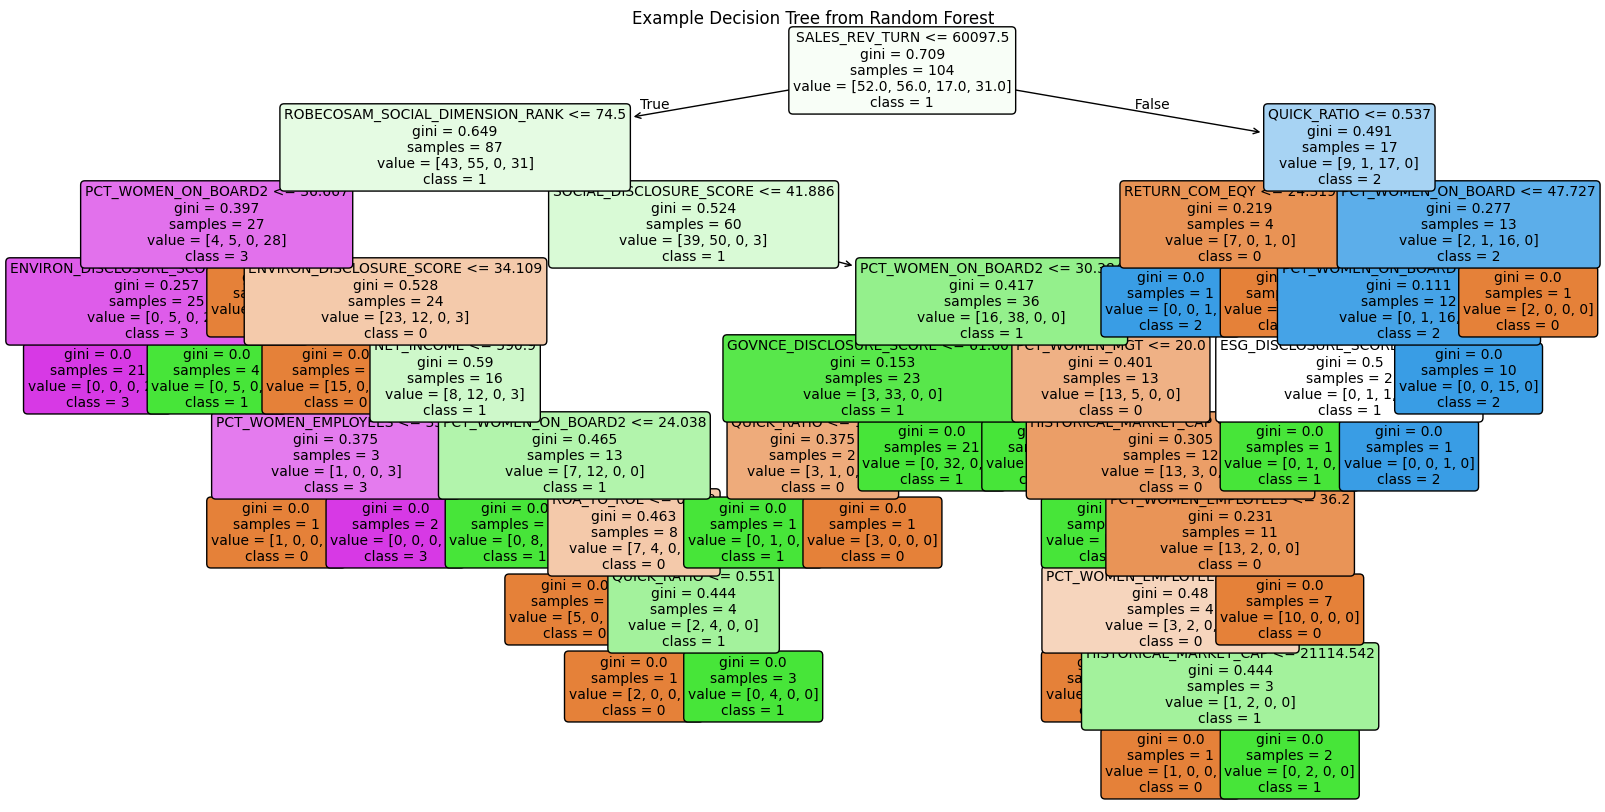

In [28]:
# --- Visualize a Single Decision Tree (Example) ---
plt.figure(figsize=(20, 10))
tree.plot_tree(rf_model.estimators_[0],
               feature_names=numerical_cols,
               class_names=[str(i) for i in range(4)],
               filled=True,
               rounded=True,
               fontsize=10)
plt.title("Example Decision Tree from Random Forest")
plt.show()

In [33]:
# --- Example: Cluster Characteristics ---
print("\nCluster Characteristics (Means):")
cluster_means = df.groupby('Cluster')[numerical_cols].mean()
print(cluster_means)


Cluster Characteristics (Means):
                 SIC  Manufacturing  DJSI  NUM_OF_EMPLOYEES     NET_ASSETS  \
Cluster                                                                      
0        5299.637599       0.377358   1.0      98122.097452   17035.012792   
1        3635.368421       0.894737   1.0      45268.002170   13885.326145   
2        4317.250000       0.562500   1.0     157286.000000  142038.937500   
3        5569.235294       0.215686   1.0      33126.215686   19003.864294   

           NET_INCOME  SALES_REV_TURN  HISTORICAL_MARKET_CAP  RETURN_ON_ASSET  \
Cluster                                                                         
0         2508.420943    37217.448717           50459.854267         7.284592   
1         1669.909737    19253.264224           43068.061465         5.698687   
2        12094.250000   106302.500000          227866.704087         4.350313   
3         1504.873333    20544.795706           28497.206143         3.209853   

         R

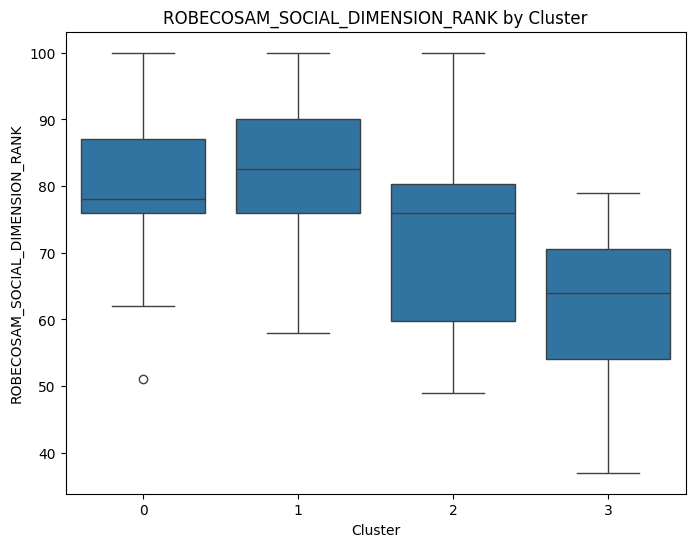

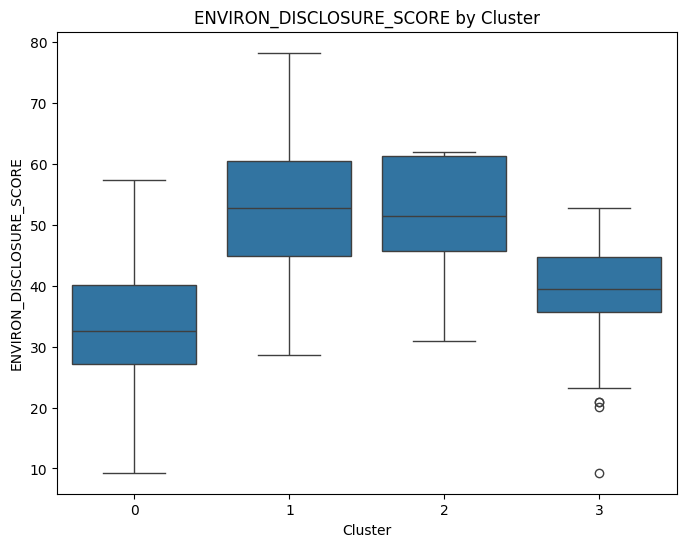

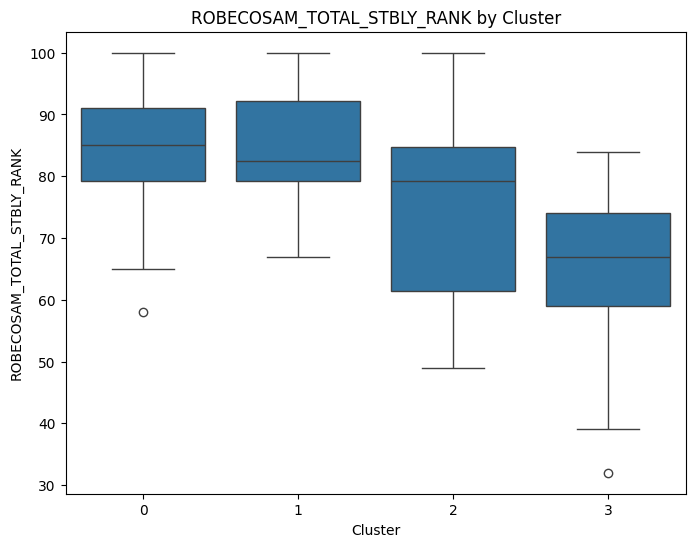

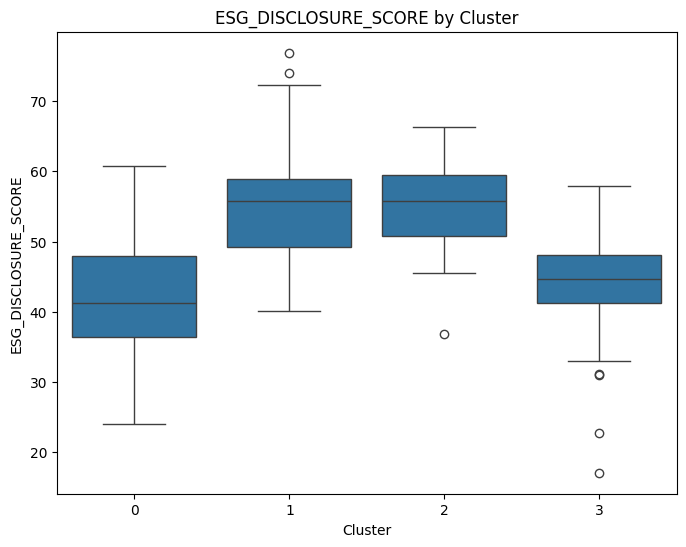

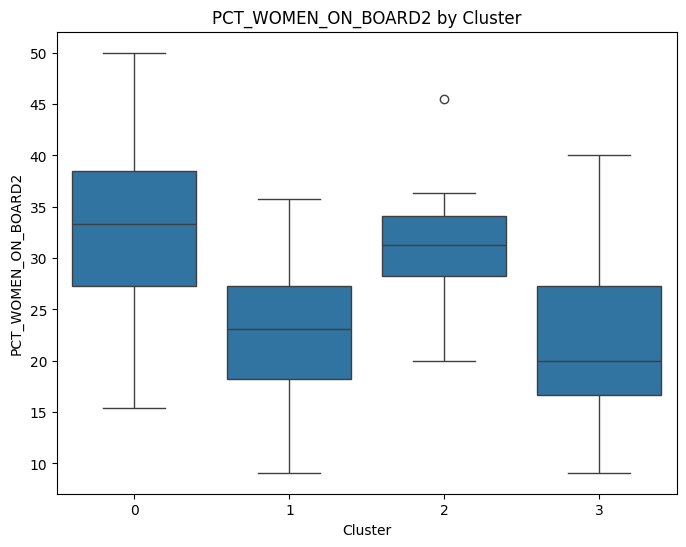

In [34]:
# --- Example: Box Plots for Key Features ---
for col in feature_importances['feature'][:5]:  # Top 5 features
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Cluster', y=col, data=df)
    plt.title(f'{col} by Cluster')
    plt.show()

In [56]:
# --- Multinomial Logit (with selected features and robustness) ---
print("-" * 30 + "\nMultinomial Logit Results:")
try:
    # Add constant to the *selected* features
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)

    # Add a tiny constant to avoid log(0) issues
    X_train_sm = X_train_sm + 1e-9
    X_test_sm = X_test_sm + 1e-9

    mnlogit_model = MNLogit(y_train, X_train_sm)
    mnlogit_results = mnlogit_model.fit(method='bfgs', maxiter=1000)  # Robust solver
    print(mnlogit_results.summary())

    y_pred_probs = mnlogit_results.predict(X_test_sm)
    y_pred_mnlogit = y_pred_probs.idxmax(axis=1)


    print("\nMultinomial Logit - Classification Report:")
    print(classification_report(y_test, y_pred_mnlogit, zero_division=0))


except Exception as e:
    print(f"Error fitting Multinomial Logit: {e}")
    print("This often indicates perfect separation or numerical instability.")
    print("Reduce the number of features further (adjust 'top_n').")
    print("Check the correlation matrix and remove highly correlated features.")

------------------------------
Multinomial Logit Results:


/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3059: RuntimeWarning: divide by zero encountered in log
  logprob = np.log(self.cdf(np.dot(self.exog,params)))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3060: RuntimeWarning: invalid value encountered in multiply
  return np.sum(d * logprob)
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3027: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/usr/local/lib/python3.11/dist-packages/statsmodels/discrete/discrete_model.py:3028: RuntimeWarning: invali

         Current function value: nan
         Iterations: 1
         Function evaluations: 112
         Gradient evaluations: 112
Error fitting Multinomial Logit: need covariance of parameters for computing (unnormalized) covariances
This often indicates perfect separation or numerical instability.
Reduce the number of features further (adjust 'top_n').
Check the correlation matrix and remove highly correlated features.
